<a href="https://colab.research.google.com/github/ishekhib/Freenove_4WD_Smart_Car_Kit_for_Raspberry_Pi/blob/docs/DS3000_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Some key imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

# 1. Data Preparation

### 1.1 Mounting drive and loading the dataset

In [ ]:
from google.colab import drive
import zipfile
import pandas as pd

#Mount Google Drive
drive.mount('/content/drive')

#Path to the ZIP file inside the shared Drive folder
zip_path = '/content/drive/MyDrive/DS3000_Project/movies.zip'

#Unzip the contents into a temporary folder in Colab
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/movies_data')

#Check that the files were extracted
!ls /content/movies_data

#Load the IMDB dataset
df = pd.read_csv('/content/movies_data/imdb-top-rated-movies-user-rated.csv')

#Display first few rows to check it has loaded
df.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
imdb-top-rated-movies-user-rated.csv


,Rank,Title,IMDb Rating,Votes,Poster URL,Video URL,Meta Score,Tags,Director,Description,Writers,Stars,Summary,Worldwide Gross
0,1,Once Upon a Time... in Hollywood,7.6,927K,https://www.imdb.com/title/tt7131622/mediaview...,https://imdb-video.media-imdb.com/vi1385741849...,84.0,"""Period Drama, Showbiz Drama, Comedy, Drama""",Quentin Tarantino,"""As Hollywood's Golden Age is winding down dur...",Quentin Tarantino,"""Leonardo DiCaprio, Brad Pitt, Margot Robbie""","""Reviewers say 'Once Upon a Time in Hollywood'...",-
1,2,Mission: Impossible - Dead Reckoning Part One,7.6,311K,https://www.imdb.com/title/tt9603212/mediaview...,https://imdb-video.media-imdb.com/vi3500918553...,81.0,"""Action Epic, Adventure Epic, Spy, Action, Adv...",Christopher McQuarrie,Ethan Hunt and his IMF team must track down a ...,"""Bruce Geller, Christopher McQuarrie, Erik Jen...","""Tom Cruise, Hayley Atwell, Ving Rhames""","""Reviewers say 'Mission: Impossible - Dead Rec...",-
2,3,John Wick: Chapter 4,7.6,392K,https://www.imdb.com/title/tt10366206/mediavie...,https://imdb-video.media-imdb.com/vi289916185/...,78.0,"""Action Epic, Gun Fu, One,Person Army Action, ...",Chad Stahelski,"""John Wick uncovers a path to defeating The Hi...","""Shay Hatten, Michael Finch, Derek Kolstad""","""Keanu Reeves, Laurence Fishburne, George Geor...","""Reviewers say 'John Wick: Chapter 4' is laude...",-
3,4,Watchmen,7.6,603K,https://www.imdb.com/title/tt0409459/mediaview...,https://imdb-video.media-imdb.com/vi240565017/...,56.0,"""Dystopian Sci,Fi, Superhero, Action, Drama, M...",Zack Snyder,"""In a version of 1985 where superheroes exist-...","""Dave Gibbons, David Hayter, Alex Tse""","""Jackie Earle Haley, Patrick Wilson, Carla Gug...","""Reviewers say 'Watchmen' is acclaimed for its...",-
4,5,The Fifth Element,7.6,533K,https://www.imdb.com/title/tt0119116/mediaview...,https://imdb-video.media-imdb.com/vi854720793/...,52.0,"""Sci,Fi Epic, Space Sci,Fi, Action, Adventure,...",Luc Besson,"""In the colorful future- a cab driver unwittin...","""Luc Besson, Robert Mark Kamen""","""Bruce Willis, Milla Jovovich, Gary Oldman""",-,-


### 1.2 Taking a first look at the data

In [ ]:
#Check the shape of the dataset
df.shape

#View general information about column names, datatypes, and missing values
df.info()

#Get a statistical summary of numeric and object columns
df.describe(include='all').T

#Check how many missing values are in each column
df.isna().sum()

#Preview random 5 rows to get a sense of the formatting
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rank             950 non-null    int64  
 1   Title            950 non-null    object 
 2   IMDb Rating      950 non-null    float64
 3   Votes            950 non-null    object 
 4   Poster URL       950 non-null    object 
 5   Video URL        918 non-null    object 
 6   Meta Score       793 non-null    float64
 7   Tags             950 non-null    object 
 8   Director         950 non-null    object 
 9   Description      950 non-null    object 
 10  Writers          950 non-null    object 
 11  Stars            949 non-null    object 
 12  Summary          298 non-null    object 
 13  Worldwide Gross  53 non-null     object 
dtypes: float64(2), int64(1), object(11)
memory usage: 104.0+ KB


,Rank,Title,IMDb Rating,Votes,Poster URL,Video URL,Meta Score,Tags,Director,Description,Writers,Stars,Summary,Worldwide Gross
470,471,The Leopard,7.9,33K,https://www.imdb.com/title/tt0057091/mediaview...,NaN,100.0,"Epic, Historical Epic, Period Drama, Drama, Hi...",Luchino Visconti,The Prince of Salina- a noble aristocrat of im...,"Giuseppe Tomasi di Lampedusa, ""Suso Cecchi DAm...","Burt Lancaster, Alain Delon, Claudia Cardinale",NaN,NaN
60,61,A Few Good Men,7.7,307K,https://www.imdb.com/title/tt0104257/mediaview...,https://imdb-video.media-imdb.com/vi1407304985...,62.0,"Legal Drama, Legal Thriller, Drama, Thriller",Rob Reiner,A military lawyer intends to prove that two US...,Aaron Sorkin,"Tom Cruise, Jack Nicholson, Demi Moore",NaN,NaN
832,833,Dial M for Murder,8.2,200K,https://www.imdb.com/title/tt0046912/mediaview...,https://imdb-video.media-imdb.com/vi3634430233...,75.0,"Crime, Drama, Mystery, Thriller",Alfred Hitchcock,A London playboy plots the perfect murder of h...,Frederick Knott,"Ray Milland, Grace Kelly, Robert Cummings",Reviewers say 'Dial M for Murder' is acclaimed...,NaN
684,685,Wild Tales,8.1,232K,https://www.imdb.com/title/tt3011894/mediaview...,https://imdb-video.media-imdb.com/vi3112877081...,77.0,"Dark Comedy, Comedy, Drama, Thriller",Damián Szifron,Six short stories that explore the extremities...,"Julian Loyola, Damián Szifron, Germán Servidio","Darío Grandinetti, María Marull, Mónica Villa",Reviewers say 'Wild Tales' is an anthology fil...,NaN
229,230,Ferris Bueller's Day Off,7.8,407K,https://www.imdb.com/title/tt0091042/mediaview...,https://imdb-video.media-imdb.com/vi2005514777...,61.0,"Buddy Comedy, Satire, Teen Comedy, Comedy",John Hughes,A brash- cocky high school senior- tired of sk...,John Hughes,"Matthew Broderick, Alan Ruck, Mia Sara",NaN,NaN


### 1.3 Defining features and target

In [ ]:
import pandas as pd

# Define the target variable
target = 'IMDb Rating'

#Keep strong predictors with good coverage
features = [
    'Votes', #fix formatting
    'Meta Score',
    'Director', #encode later
    'Tags', #encode later
    'Stars', #encode later
    'Writers' #encode later
]

#Create working dataframe
df_model = df[features + [target]].copy()

#Checking the format of the votes since it was displaying NaN
df['Votes'].unique()[:20]  #show the first 20 unique values

#Clean Votes column formatting: '927K' -> 927000
def convert_votes(v):
    v = str(v).strip()
    if v.endswith('K'):
        # '927K' -> 927000
        return float(v[:-1]) * 1_000
    elif v.endswith('M'):
        #just in case there are '1.2M' style values
        return float(v[:-1]) * 1_000_000
    else:
        # fallback: try numeric, otherwise NaN
        return pd.to_numeric(v, errors='coerce')

df_model['Votes'] = df_model['Votes'].apply(convert_votes)

#Drop any rows missing the target, they wont be useful for training or testing
df_model = df_model.dropna(subset=[target])

#Another quick check of structure to check if the changes went through as expected
df_model.info()
df_model.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Votes        950 non-null    float64
 1   Meta Score   793 non-null    float64
 2   Director     950 non-null    object 
 3   Tags         950 non-null    object 
 4   Stars        949 non-null    object 
 5   Writers      950 non-null    object 
 6   IMDb Rating  950 non-null    float64
dtypes: float64(3), object(4)
memory usage: 52.1+ KB


,Votes,Meta Score,Director,Tags,Stars,Writers,IMDb Rating
0,927000.0,84.0,Quentin Tarantino,"""Period Drama, Showbiz Drama, Comedy, Drama""","""Leonardo DiCaprio, Brad Pitt, Margot Robbie""",Quentin Tarantino,7.6
1,311000.0,81.0,Christopher McQuarrie,"""Action Epic, Adventure Epic, Spy, Action, Adv...","""Tom Cruise, Hayley Atwell, Ving Rhames""","""Bruce Geller, Christopher McQuarrie, Erik Jen...",7.6
2,392000.0,78.0,Chad Stahelski,"""Action Epic, Gun Fu, One,Person Army Action, ...","""Keanu Reeves, Laurence Fishburne, George Geor...","""Shay Hatten, Michael Finch, Derek Kolstad""",7.6
3,603000.0,56.0,Zack Snyder,"""Dystopian Sci,Fi, Superhero, Action, Drama, M...","""Jackie Earle Haley, Patrick Wilson, Carla Gug...","""Dave Gibbons, David Hayter, Alex Tse""",7.6
4,533000.0,52.0,Luc Besson,"""Sci,Fi Epic, Space Sci,Fi, Action, Adventure,...","""Bruce Willis, Milla Jovovich, Gary Oldman""","""Luc Besson, Robert Mark Kamen""",7.6


### 1.4 Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

# Target column (already defined earlier, but just to be explicit)
target = 'IMDb Rating'

# Features we’ll use as predictors
feature_cols = ['Votes', 'Meta Score', 'Director', 'Tags', 'Stars', 'Writers']

X = df_model[feature_cols]
y = df_model[target]

# Identify numeric and categorical features
numeric_features = ['Votes', 'Meta Score']
categorical_features = ['Director', 'Tags', 'Stars', 'Writers']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0
)

X_train.shape, X_test.shape

((760, 6), (190, 6))

### 1.5 Building the preprocessing pipeline for scaling and encoding

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge


#Numeric pipeline: impute (fill missing data with median of the column) + scale
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  #handles NaNs in Votes/Meta Score
    ("scaler", StandardScaler())                    #normalization
])

#Categorical pipeline: impute + one-hot encode categorical values
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  #this works for our data since we are only missing 1 value
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     #creates dummy variables
])

#Combine them with ColumnTransformerdoe
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

preprocessor #Display our pipeline, later it will be added to a ridge pipeline or other models


ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Votes', 'Meta Score']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Director', 'Tags', 'Stars', 'Writers'])])

### 1.6 Summarizing the cleaned data et

In [ ]:
# Summarize and describe the cleaned dataset
print("Dataset Overview")
print("-" * 40)
print(f"Shape: {df_model.shape[0]} rows × {df_model.shape[1]} columns\n")

print("Column Data Types:")
print(df_model.dtypes)
print("\n")

print("Missing Values per Column:")
print(df_model.isna().sum())
print("\n")

print("Statistical Summary (Numeric Features):")
display(df_model.describe())
print("\n")

print("Random Sample of Rows:")
display(df_model.sample(5, random_state=0))



Dataset Overview
----------------------------------------
Shape: 950 rows × 7 columns

Column Data Types:
Votes          float64
Meta Score     float64
Director        object
Tags            object
Stars           object
Writers         object
IMDb Rating    float64
dtype: object


Missing Values per Column:
Votes            0
Meta Score     157
Director         0
Tags             0
Stars            1
Writers          0
IMDb Rating      0
dtype: int64


Statistical Summary (Numeric Features):


,Votes,Meta Score,IMDb Rating
count,9.500000e+02,793.000000,950.000000
mean,3.073916e+05,79.142497,7.944632
std,3.480085e+05,11.864497,0.217292
min,2.600000e+04,30.000000,7.600000
25%,6.200000e+04,72.000000,7.800000
50%,1.495000e+05,80.000000,7.900000
75%,4.575000e+05,88.000000,8.100000
max,1.900000e+06,100.000000,8.500000




Random Sample of Rows:


,Votes,Meta Score,Director,Tags,Stars,Writers,IMDb Rating
872,1100000.0,96.0,John Lasseter,"Buddy Comedy, Computer Animation, Supernatural...","Tom Hanks, Tim Allen, Don Rickles","John Lasseter, Pete Docter, Andrew Stanton",8.3
568,130000.0,93.0,Federico Fellini,"Dark Comedy, Epic, Psychological Drama, Showbi...","Marcello Mastroianni, Anouk Aimée, Claudia Car...","Federico Fellini, Ennio Flaiano, Tullio Pinelli",8.0
249,111000.0,55.0,David Mickey Evans,"Baseball, Coming,of,Age, Teen Comedy, Teen Dra...","Tom Guiry, Mike Vitar, Art LaFleur","David Mickey Evans, Robert Gunter",7.8
331,85000.0,62.0,Hal Ashby,"Coming,of,Age, Quirky Comedy, Romantic Comedy,...","Ruth Gordon, Bud Cort, Vivian Pickles",Colin Higgins,7.8
492,65000.0,97.0,Cristian Mungiu,"Period Drama, Psychological Drama, Tragedy, Drama","Anamaria Marinca, Laura Vasiliu, Vlad Ivanov",Cristian Mungiu,7.9


# 2. EDA (Exploratory Data Analysis)

###2.1 Correlation Matrix and Heat Map

In [ ]:
# Helper functions
def simplify_multilabel(X):
    """
    Simplify multi-label columns by taking the first item in the comma-separated list.
    """
    X_copy = X.copy()
    for col in X_copy.columns:
        X_copy[col] = X_copy[col].apply(
            lambda x: np.nan if pd.isna(x) else str(x).split(',')[0].strip()
        )
    return X_copy

def simple_onehot(X):
    """
    Apply simple one-hot encoding using pd.get_dummies.
    """
    return pd.get_dummies(X, drop_first=True)

# Feature selection
numeric_features = ['Votes', 'Meta Score']
ml_features = ['Director', 'Tags', 'Stars', 'Writers']
target = 'IMDb Rating'

X = df_model[numeric_features + ml_features]
y = df_model[target]

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Convert processed arrays to DataFrames safely

# Numeric columns: scale manually to preserve column names
numeric_train_scaled = pd.DataFrame(
    numerical_transformer.fit_transform(X_train[numeric_features]),
    columns=numeric_features,
    index=X_train.index
)
numeric_test_scaled = pd.DataFrame(
    numerical_transformer.transform(X_test[numeric_features]),
    columns=numeric_features,
    index=X_test.index
)

# Categorical columns: simplify + one-hot
categorical_train_df = simple_onehot(simplify_multilabel(X_train[ml_features]))
categorical_test_df = simple_onehot(simplify_multilabel(X_test[ml_features]))

# Ensure test columns align with training columns
categorical_test_df = categorical_test_df.reindex(
    columns=categorical_train_df.columns, fill_value=0
)

# Combine numeric and categorical
X_train_df = pd.concat([numeric_train_scaled, categorical_train_df], axis=1)
X_test_df = pd.concat([numeric_test_scaled, categorical_test_df], axis=1)

In [ ]:
# Rank features by correlation with IMDb Rating
train_with_target = X_train_df.copy()
train_with_target[target] = y_train

target_corr = train_with_target.corr()[target].drop(target)
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

print("\nTop features correlated with IMDb Rating:")
print(target_corr_sorted.head(20))

# Strong correlations (>0.5)
corr_matrix = X_train_df.corr()
strong_corr = corr_matrix[abs(corr_matrix) > 0.5].stack().reset_index()
strong_corr = strong_corr[strong_corr['level_0'] != strong_corr['level_1']]
strong_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
strong_corr = strong_corr.drop_duplicates(subset=['Correlation']).sort_values(by='Correlation', ascending=False)

print("\nStrong correlations (>0.5):")
print(strong_corr)


Top features correlated with IMDb Rating:
Votes                          0.308344
Meta Score                     0.205296
Director_Billy Wilder          0.126996
Stars_Sigourney Weaver         0.119883
Tags_"Dark Comedy             -0.098773
Tags_"Period Drama            -0.098773
Writers_Lokesh Kanagaraj       0.096298
Director_Lokesh Kanagaraj      0.096298
Director_Lee Unkrich           0.096298
Stars_Kevin Spacey             0.096298
Writers_Billy Wilder           0.094617
Director_Christopher Nolan     0.094617
Tags_Action Epic               0.093811
Writers_Jonathan Nolan         0.093048
Writers_"Dan OBannon"          0.093048
Director_Joaquim Dos Santos    0.093048
Stars_Shameik Moore            0.093048
Writers_Phil Lord              0.093048
Writers_David Franzoni         0.093048
Writers_Denis Villeneuve       0.093048
Name: IMDb Rating, dtype: float64

Strong correlations (>0.5):
                       Feature 1                  Feature 2  Correlation
3      Director_Abbas

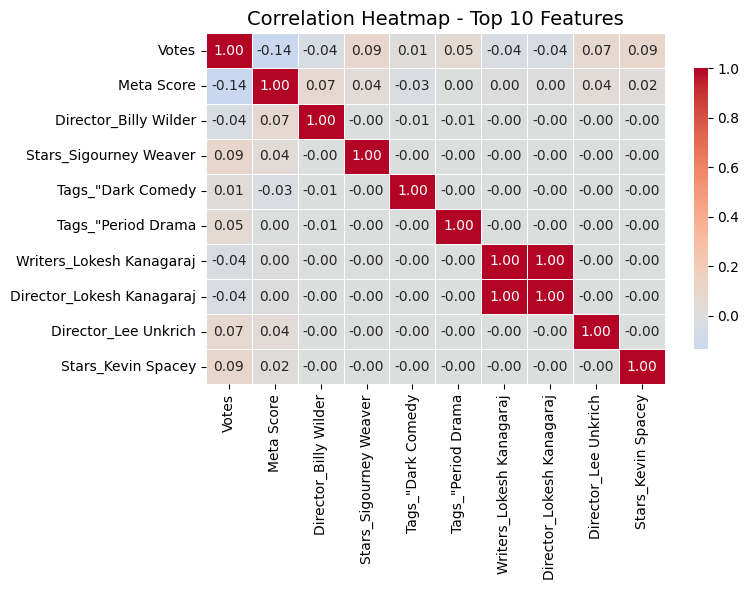

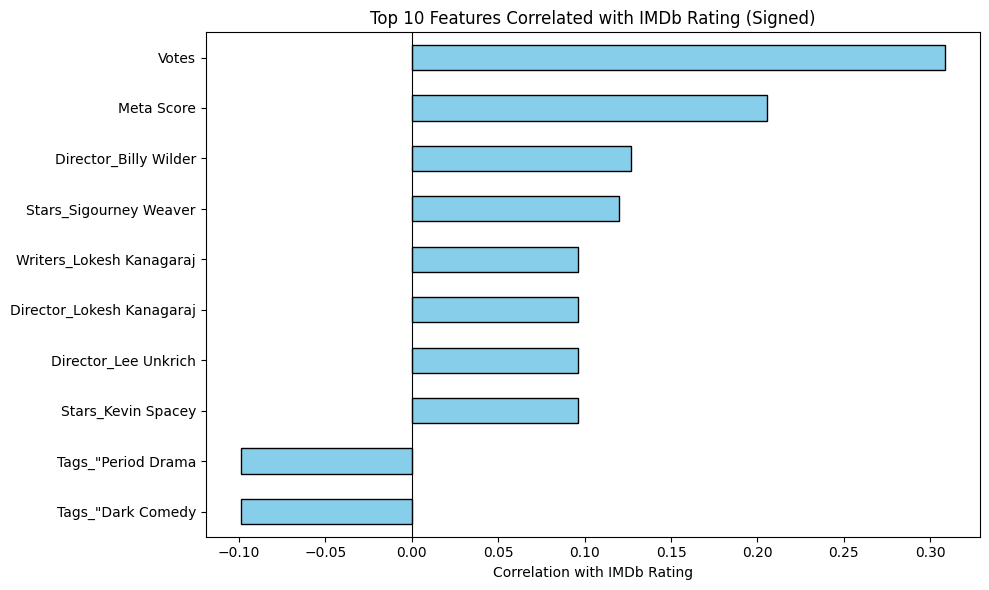

In [ ]:
# Simplified heatmap for top 10 features
top10_features = target_corr_sorted.head(10).index.tolist()
corr_top10 = X_train_df[top10_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_top10,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap - Top 10 Features", fontsize=14)
plt.tight_layout()
plt.show()

# Plot top 10 features correlated with IMDb Rating (signed)
top_features_signed = target_corr_sorted.head(10)

plt.figure(figsize=(10, 6))
top_features_signed.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel("Correlation with IMDb Rating")
plt.title("Top 10 Features Correlated with IMDb Rating (Signed)")
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


###2.2 Histograms

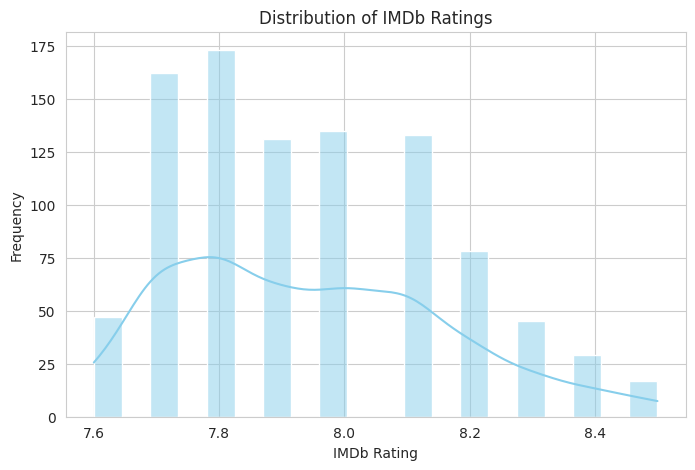

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean plotting style for better visualization
sns.set_style("whitegrid")

# Create a histogram for 'IMDb Rating'
plt.figure(figsize=(8, 5))
sns.histplot(df_model['IMDb Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of IMDb Ratings')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.show()



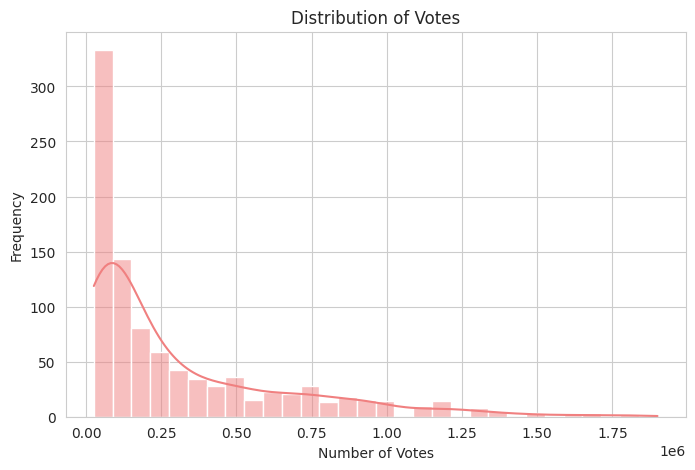

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean plotting style for better visualization
sns.set_style("whitegrid")

# Create a histogram for 'Votes'
plt.figure(figsize=(8, 5))
sns.histplot(df_model['Votes'], bins=30, kde=True, color='lightcoral')
plt.title('Distribution of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

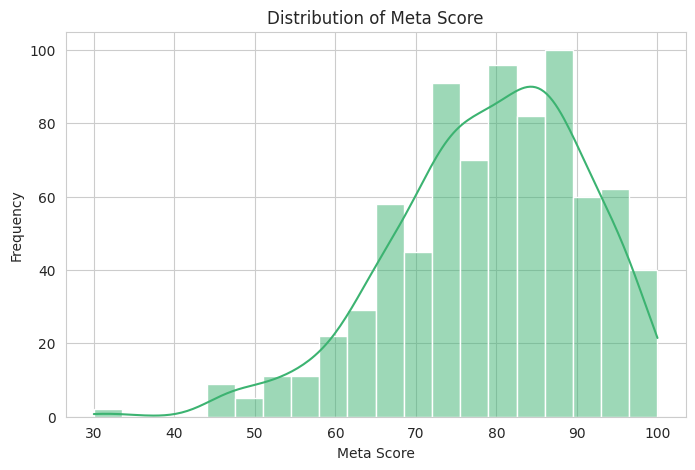

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean plotting style for better visualization
sns.set_style("whitegrid")

# Create a histogram for 'Meta Score'
plt.figure(figsize=(8, 5))
sns.histplot(df_model['Meta Score'], bins=20, kde=True, color='mediumseagreen')
plt.title('Distribution of Meta Score')
plt.xlabel('Meta Score')
plt.ylabel('Frequency')
plt.show()

###2.3 Pair Plots

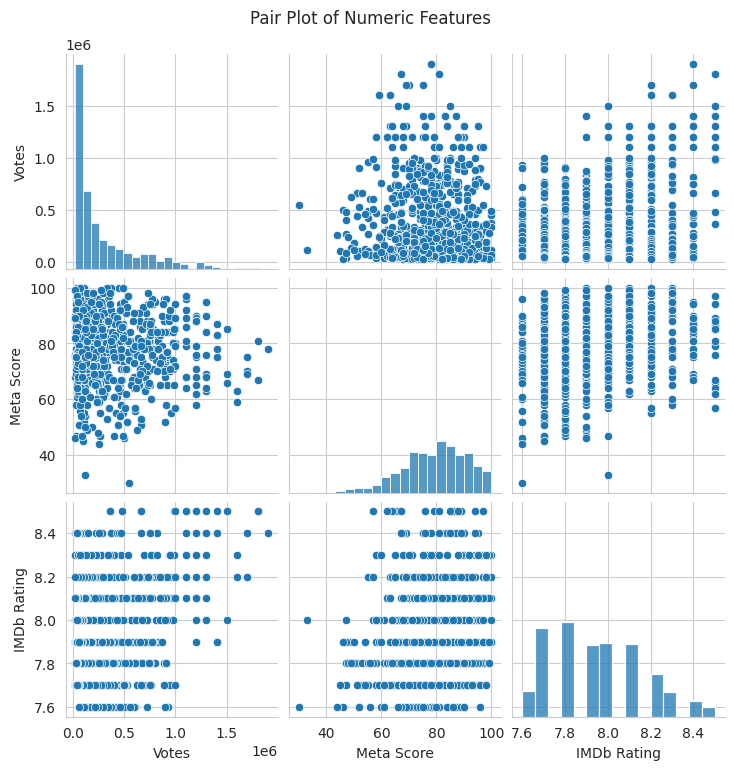

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot for the numeric features in df_model
# This will show scatter plots for each pair of variables and histograms for individual variables
sns.pairplot(df_model[['Votes', 'Meta Score', 'IMDb Rating']])
plt.suptitle('Pair Plot of Numeric Features', y=1.02) # Add a main title for the plot
plt.show()

#3. Regression Models

###3.1 Making and comparing the baseline models

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Helper function to evaluate models
def evaluate_regressor(name, regressor, X_train, X_test, y_train, y_test):
    # Build pipeline with a fresh preprocessor
    model_pipeline = Pipeline(steps=[
        ("preprocessor", clone(preprocessor)),
        ("regressor", regressor)
    ])

    # Fit and predict
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # Compute evaluation metrics
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²": r2_score(y_test, y_pred)
    }

# Define baseline models
models = [
    ("Dummy (Mean)", DummyRegressor(strategy="mean")),
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0, random_state=0)),
    ("Random Forest", RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1))
]

# Evaluate all models
results = []
for name, model in models:
    metrics = evaluate_regressor(name, model, X_train, X_test, y_train, y_test)
    results.append(metrics)

# Display results
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("Baseline Model Performance (Test Set):")
display(results_df)


Baseline Model Performance (Test Set):


,Model,MAE,RMSE,R²
2,Ridge Regression,0.158683,0.190885,0.206749
3,Random Forest,0.158153,0.193256,0.186920
0,Dummy (Mean),0.182547,0.214819,-0.004644
1,Linear Regression,2.053424,2.722552,-160.368959


###3.2 Fine tune the best baseline model (Ridge Regression)

In [ ]:
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {
    "regressor__alpha": [0.01, 0.1, 1, 5, 10, 25, 50, 100, 200]
}

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", ridge)
])

grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("Tuning Ridge Regression...")
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_r2 = r2_score(y_test, y_pred_tuned)

print("Tuned Ridge Performance:")
print("MAE:", tuned_mae)
print("RMSE:", tuned_rmse)
print("R^2:", tuned_r2)

#Since best alpha is 1, we do not need to fine tune!

Tuning Ridge Regression...
Best params: {'regressor__alpha': 1}
Best CV RMSE: 0.196282503494007
Tuned Ridge Performance:
MAE: 0.15868337304202998
RMSE: 0.1908848235188924
R^2: 0.2067492825521633


###3.3 Feature Importance

In [ ]:
#Extract feature names after preprocessing
import numpy as np

#Numeric feature names
num_features = numeric_features  # from your earlier code

#Categorical feature names
cat_transformer = preprocessor.named_transformers_["categorical"]
encoder = cat_transformer.named_steps["onehot"]
cat_feature_names = encoder.get_feature_names_out(categorical_features)

#Combine numeric + categorical
all_features = np.concatenate([num_features, cat_feature_names])

len(all_features)

#Extract the final ridge model
ridge_model = best_model.named_steps["regressor"]

coefficients = ridge_model.coef_

#Put into a DataFrame for easy interpretation
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefficients
})

#Sort by absolute importance
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df_sorted = coef_df.sort_values(by="abs_coef", ascending=False)

coef_df_sorted.head(15)


,feature,coefficient,abs_coef
43,Director_Billy Wilder,0.182034,0.182034
250,Director_Lokesh Kanagaraj,0.155915,0.155915
1166,"Stars_""Leonardo DiCaprio, Brad Pitt, Margot Ro...",-0.154028,0.154028
492,"Tags_""Period Drama, Showbiz Drama, Comedy, Drama""",-0.154028,0.154028
17,Director_Alfonso Cuarón,-0.153361,0.153361
663,"Tags_Comedy, Drama, Romance",0.150950,0.150950
2542,Writers_Taylor Sheridan,-0.148910,0.148910
341,Director_Rajkumar Hirani,0.139021,0.139021
497,"Tags_Action Epic, Adult Animation, Adventure E...",0.124277,0.124277
1901,"Stars_Yôji Matsuda, Yuriko Ishida, Yûko Tanaka",0.124277,0.124277


### 3.4 Detailed Model Evaluation: Predictions vs. Actuals

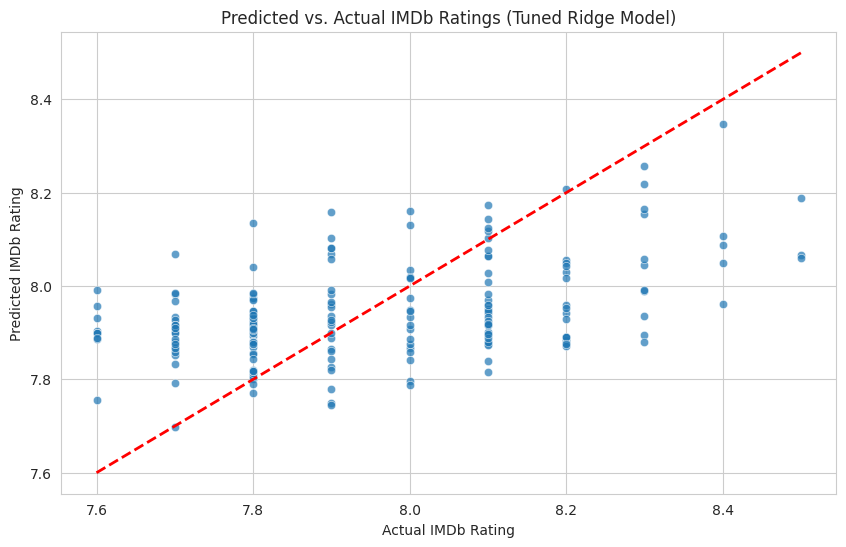

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Plotting Predicted vs Actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_tuned, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line for perfect prediction
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.title("Predicted vs. Actual IMDb Ratings (Tuned Ridge Model)")
plt.show()


### 3.5 Detailed Model Evaluation: Residual Analysis

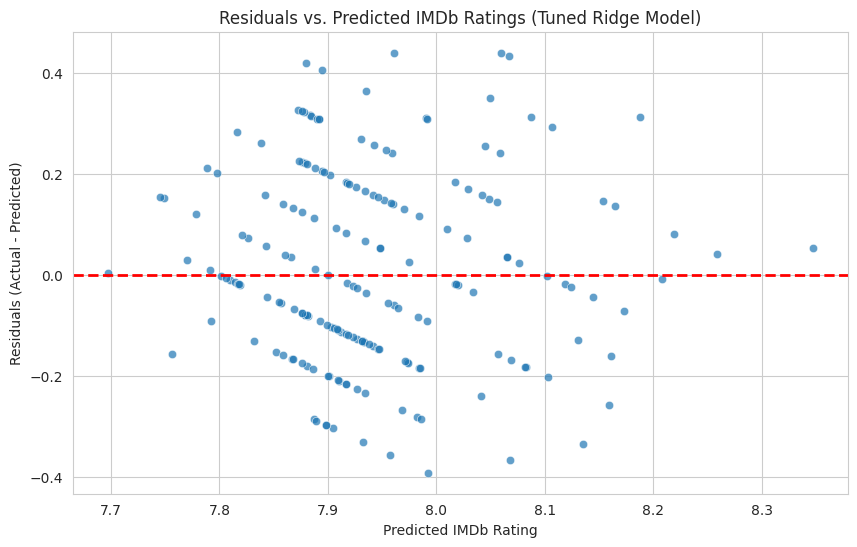

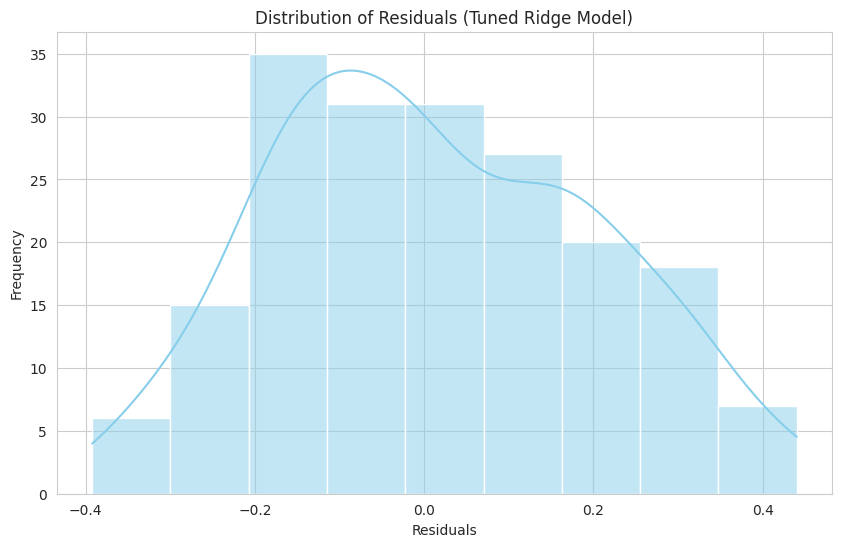

In [ ]:
# Calculate residuals
residuals = y_test - y_pred_tuned

# Plotting Residuals vs. Predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_tuned, y=residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2) # Zero line
plt.xlabel("Predicted IMDb Rating")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted IMDb Ratings (Tuned Ridge Model)")
plt.show()

# Plotting the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Tuned Ridge Model)")
plt.show()


# 4. User Interface

In [ ]:
import joblib
joblib.dump(best_model, "ridge_pipeline.pkl")

['ridge_pipeline.pkl']

In [ ]:
pip install streamlit scikit-learn pandas numpy

In [ ]:
# ==============================
# IMDb Rating Prediction Interface
# ==============================

# ------------------------------
# 1. Imports
# ------------------------------
import pandas as pd
import numpy as np
import streamlit as st
import joblib

# Load trained Ridge pipeline
pipe = joblib.load("ridge_pipeline.pkl")

# ------------------------------
# 2. Streamlit Interface
# ------------------------------

st.title("IMDb Rating Prediction")
st.write("""
Predict IMDb ratings for movies using a pre-trained Ridge Regression model.
You can either input a single movie manually or upload a CSV for batch predictions.
""")

# ------------------------------
# 2.1 Manual Input Form
# ------------------------------
st.header("Predict a Single Movie")

with st.form("single_movie_form"):
    votes = st.number_input("Votes", min_value=0, step=1, value=1000)
    meta_score = st.number_input("Meta Score", min_value=0, max_value=100, value=75)
    director = st.text_input("Director", value="Christopher Nolan")
    tags = st.text_input("Tags (comma-separated)", value="Action, Sci-Fi")
    stars = st.text_input("Stars (comma-separated)", value="Leonardo DiCaprio")
    writers = st.text_input("Writers (comma-separated)", value="Jonathan Nolan")
    submitted = st.form_submit_button("Predict IMDb Rating")

if submitted:
    # Prepare input for prediction
    input_df = pd.DataFrame([{
        "Votes": votes,
        "Meta Score": meta_score,
        "Director": director,
        "Tags": tags,
        "Stars": stars,
        "Writers": writers
    }])

    pred = pipe.predict(input_df)[0]
    st.success(f"Predicted IMDb Rating: {pred:.2f}")

# ------------------------------
# 2.2 Batch Prediction via CSV
# ------------------------------
st.header("Batch Prediction (CSV Upload)")

uploaded_file = st.file_uploader("Upload a CSV file with columns: Votes, Meta Score, Director, Tags, Stars, Writers", type=["csv"])

if uploaded_file is not None:
    batch_df = pd.read_csv(uploaded_file)

    # Predict IMDb ratings
    batch_df["Predicted IMDb Rating"] = pipe.predict(batch_df)

    st.subheader("Predictions")
    st.dataframe(batch_df)

    # Download button
    csv = batch_df.to_csv(index=False).encode('utf-8')
    st.download_button(
        label="Download Predictions as CSV",
        data=csv,
        file_name="imdb_predictions.csv",
        mime="text/csv"
    )

# ------------------------------
# 2.3 Optional: Display Feature Importance
# ------------------------------
if st.checkbox("Show Top Features"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract feature importance
    numeric_features = ['Votes', 'Meta Score']
    categorical_features = ['Director', 'Tags', 'Stars', 'Writers']
    cat_encoder = pipe.named_steps["preprocessor"].named_transformers_["categorical"].named_steps["onehot"]
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
    all_features = np.concatenate([numeric_features, cat_feature_names])

    ridge_model = pipe.named_steps["regressor"]
    coef_df = pd.DataFrame({
        "feature": all_features,
        "coefficient": ridge_model.coef_
    })
    coef_df["abs_coef"] = coef_df["coefficient"].abs()
    coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False).head(15)

    st.write("Top 15 Most Important Features")
    st.dataframe(coef_df_sorted)

    # Bar plot
    plt.figure(figsize=(10,6))
    sns.barplot(x="coefficient", y="feature", data=coef_df_sorted, palette="viridis")
    plt.title("Feature Importance (Ridge Model)")
    st.pyplot(plt)


2025-12-02 00:47:58.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 00:47:58.654 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 00:47:58.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 00:47:58.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 00:47:58.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 00:47:58.668 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 00:47:58.671 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 00:47:58.674 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar